# Data cleaning

Our first step will be to clean the data obtained from the [ramens rating kaggle entry](https://www.kaggle.com/residentmario/ramen-ratings) found in the `./raw_data/ramen_ratings.csv` and integrate the the data from the [World Instant Noodle Association](https://instantnoodles.org/en/noodles/market.html) in one dataset.

## Covered in this notebook

1. Exploration of column content.
2. Validating the quality of the data:
 * Weird values
 * Badly formatted data
 * Missing data
3. Outputting subset csv file.
 
## Exploring column content
 
We start by importing pandas which we will use to read the orignal csv and select a few columns.

In [191]:
import pandas as pd
rr_df = pd.read_csv('../raw_data/ramen_ratings.csv');

We verify that the data was loaded properly by outputting a couple of rows and the dimensions of the dataframe.

In [192]:
rr_df.head(5)

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


In [193]:
print('The ramen ratings table has {0} rows {1} columns'.format(*rr_df.shape))

The ramen ratings table has 2580 rows 7 columns


For this analysis we will not be using the `Review #` and although information about the `Top Ten` is interesting, it will not be very useful for our regression efforts. Let's start by removing these two columns.

In [194]:
rr_df = rr_df.drop(columns=["Review #", "Top Ten"])
rr_df.head()

,Brand,Variety,Style,Country,Stars
0,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75
1,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1
2,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25
3,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75
4,Ching's Secret,Singapore Curry,Pack,India,3.75


## Validating data quality

We will now look for null values for the different columns. We will proceed in order from left to right.

* Brand & Variety are strings. We will be looking for empty / null values.
* Style should be a categorical variable, we will be using a bar chart to look at the distribution of the different values.
* Country is also a categorical variable, but should be a list of known value. We will be using the package `pycountry` to validate our values.
* Stars is the variable we are trying to predict and is represented by a positive float. We will validate that all values are present and positive.


### Brand & Variety

In [195]:
def null_by_column(df, column):
    print("The number of null values for the {0} column is : {1}".format(column, pd.isnull(rr_df[column]).sum()))

def empty_by_column(df, column):
    print("The number of empty values for the {0} column is : {1}".format(column, (rr_df[column] == "").sum()))
    
null_by_column(rr_df, "Brand")
empty_by_column(rr_df, "Brand")
print('')
null_by_column(rr_df, "Variety")
empty_by_column(rr_df, "Variety")

The number of null values for the Brand column is : 0
The number of empty values for the Brand column is : 0

The number of null values for the Variety column is : 0
The number of empty values for the Variety column is : 0


A visual inspection of the dataset also revealed all characters in the dataset are non-unicode english characters.

### Style

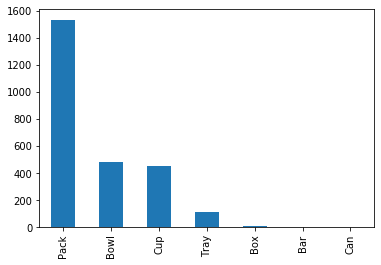

In [196]:
rr_df['Style'].value_counts().plot.bar()

Great! Our dataset has a limited number of options for "Style". We see that our distribution is skewed "Pack" instant noodles representing the majority of our dataset. We will have to be careful about this distribution when training our classification model.

### Country

1. We obtain the list of ISO format country names from the pycountry package.
2. We validate that the country columns match with a value in pycountry.
3. We will do a visual inspection of non-matching countries in our dataset.

In [197]:
import pycountry as pyc

# 1. Obtain list of countries
country_names = set([c.name for c in pyc.countries])

# 2. Validate matches for country column
rr_df_unrecognized_country = rr_df[rr_df['Country'].apply(lambda x: x not in country_names)]

# 3. Visual inspection
rr_df_unrecognized_country['Country'].value_counts()

USA            323
South Korea    309
Taiwan         224
Vietnam        108
UK              69
Holland          4
Sarawak          3
Dubai            3
Name: Country, dtype: int64

For convenience we will be renaming countries using the Map below to comply with the ISO code. Some countries are not recognized/part of the ISO codes, but the names used above are more intuitive, we will keep them as is.

In [198]:
country_name_map = {
    "USA": "United States",
    "UK": "United Kingdom",
    "Holland": "Netherlands",
    "Sarawak": "Malaysia",
    "Dubai": "United Arab Emirates"
}

In [199]:
rr_df["Country"] = rr_df["Country"].apply(lambda c: c if c in country_names else (c if c not in country_name_map else country_name_map[c]))

In [200]:
rr_df_unrecognized_country = rr_df[rr_df['Country'].apply(lambda x: x not in country_names)]

In [201]:
rr_df_unrecognized_country['Country'].value_counts()

South Korea    309
Taiwan         224
Vietnam        108
Name: Country, dtype: int64

## Integrating consumption data

Now that we have validated the values in our dataset, we will try to integrate the consumption data from the World Instant Noodle association.

In [202]:
rcbc_df = pd.read_csv("../raw_data/ramen_consumption_by_country.tsv", sep='\t')

Before merging let's figure out which countries may be missing / missnamed from our WINA dataset.

In [203]:
# Create list of countries from original dataset
rr_countries = set(rr_df['Country'])

# Create list of countries from WINA dataset
rcbc_countries = set(rcbc_df['Country / Region'])

# Print missing in WINA
for c in rr_countries:
    if c not in rcbc_countries:
        print(c)

United Arab Emirates
United Kingdom
Ghana
Vietnam
United States
South Korea
Estonia
Hong Kong
Fiji
China


Looking at the WINA dataset we see that China/Hong Kong are grouped, the United Kingdom is written as UK, the United States as USA, Vietname as Viet Nam and South Korea as Republic of Korea leaving:

* United Arab Emirates
* Fiji
* Estonia
* Ghana

not represented in our list. We will first group China and Hong Kong together in our ramen ratings dataset and will then fix the names in the WINA dataset to match the ramen ratings dataset and verify how many rows would be lost if we remove the above list or if we should use the "Others" row of the WINA dataset to keep these 4 countries.

In [204]:
rcbc_df['Country / Region'] 

1       China/Hong Kong
2             Indonesia
3                 India
4                 Japan
5              Viet Nam
6                   USA
7           Philippines
8     Republic of Korea
9              Thailand
10               Brazil
11               Russia
12              Nigeria
13                Nepal
14             Malaysia
15               Mexico
16               Taiwan
17              Myanmar
18         Saudi Arabia
19            Australia
20                   UK
21             Cambodia
22              Ukraine
23           Bangladesh
24               Poland
25         South Africa
26            Guatemala
27                Egypt
28              Germany
29               Canada
30             Pakistan
31           Kazakhstan
32            Sri Lanka
33                 Peru
34            Singapore
35           Uzbekistan
36       Czech Republic
37          New Zealand
38             Ethiopia
39                Spain
40               France
41               Turkey
42              

In [205]:
wina_country_mapping = {
    "UK": "United Kingdom",
    "Viet Nam": "Vietnam",
    "USA": "United States",
    "Republic of Korea": "South Korea"
}

# Renaming of WINA countries
rcbc_df["Country_revised"] = rcbc_df["Country / Region"].apply(lambda c: c if c not in wina_country_mapping else wina_country_mapping[c])

# Merging of China/Hong Kong
rr_df["Country"] = rr_df["Country"].apply(lambda c: c if not (("Hong Kong" in c) or ("China" in c)) else "China/Hong Kong")

We now merge the datasets.

In [206]:
merged_df = rr_df.merge(rcbc_df, left_on='Country', right_on='Country_revised', how='left')

Let's take a look at the rows without a match

In [207]:
merged_df[pd.isnull(merged_df['Country / Region'])]

,Brand,Variety,Style,Country,Stars,Country / Region,2014,2015,2016,2017,2018,Country_revised
26,Yum-Mie,Instant Noodles Beef In Light Soup Flavour,Pack,Ghana,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,Lele,Instant Noodles Beef,Pack,Ghana,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,Maggi,2 Minute Noodles Chicken Flavour,Pack,Fiji,3.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,Maggi,2 Minute Noodles Curry Flavour,Pack,Fiji,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1480,Baltix,Instant Noodles With Chicken Flavour Broth,Pack,Estonia,3.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1481,Baltix,Instant Noodles With Beef Flavour Broth,Pack,Estonia,3.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1681,FMF,Chow Tomato,Pack,Fiji,4.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1683,FMF,Chow Masala,Pack,Fiji,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1783,Golden Mie,Vegetable,Pack,United Arab Emirates,3.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1838,Golden Mie,chicken,Pack,United Arab Emirates,3.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As I am not confident about an imputation strategy using the "Others" column of the WINA dataset. I will simply drop these columns.

In [208]:
merged_df = merged_df[~pd.isnull(merged_df['Country / Region'])]

In [209]:
merged_df.head()

,Brand,Variety,Style,Country,Stars,Country / Region,2014,2015,2016,2017,2018,Country_revised
0,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,Japan,"5,500","5,540","5,660","5,660","5,780",Japan
1,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,Taiwan,710,680,770,820,830,Taiwan
2,Nissin,Cup Noodles Chicken Vegetable,Cup,United States,2.25,USA,"4,280","4,080","4,100","4,130","4,400",United States
3,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,Taiwan,710,680,770,820,830,Taiwan
4,Ching's Secret,Singapore Curry,Pack,India,3.75,India,"5,340","3,260","4,270","5,420","6,060",India


In [210]:
merged_df = merged_df.drop(columns=['Country_revised', 'Country / Region'])

In [211]:
merged_df.head()

,Brand,Variety,Style,Country,Stars,2014,2015,2016,2017,2018
0,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,"5,500","5,540","5,660","5,660","5,780"
1,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,710,680,770,820,830
2,Nissin,Cup Noodles Chicken Vegetable,Cup,United States,2.25,"4,280","4,080","4,100","4,130","4,400"
3,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,710,680,770,820,830
4,Ching's Secret,Singapore Curry,Pack,India,3.75,"5,340","3,260","4,270","5,420","6,060"


We can now remove the duplicated Country_revised column and write the result to a clean data frame csv file.

In [212]:
merged_df.to_csv("../clean_data/clean_ramen_ratings.csv", encoding='utf-8', index=False)